Mount and function:

In [5]:
# Montiamo il drive
from google.colab import drive
drive.mount('/content/drive')

print("Drive montato...")

Mounted at /content/drive
Drive montato...


In [ ]:
!pip install mediapipe

Extraction:

In [ ]:
import csv
import os
import cv2 
import mediapipe as mp
import itertools
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

#return number of faces and return coordinates of all the elements
def TESS(sample_img):
  face_mesh_images = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=2,
                                         min_detection_confidence=0.5)
  face_mesh_results = face_mesh_images.process(sample_img[:, :, ::-1])

  ELEMENTS = list(set(itertools.chain(*mp_face_mesh.FACEMESH_TESSELATION)))
  if face_mesh_results.multi_face_landmarks:

    for face_no, face_landmarks in enumerate(face_mesh_results.multi_face_landmarks):

      num=face_no + 1
      keypoints = []
      for ITEM in ELEMENTS[:]:
        coord = face_landmarks.landmark[ITEM]
        keypoints.append([coord.x, coord.y, coord.z])
    return num, keypoints

#Prendo il path della cartella cohn-kanade-images
pathImgDir = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/Dataset/cohn-kanade-images')
path, dirs, files = next(os.walk(pathImgDir))
dirs.sort()

j = slice(0,123)
#Itero per ogni cartella
for x in dirs[j]:
    pathImgSubDir = pathImgDir + '/' + x
    subPath, subDirs, subFiles = next(os.walk(pathImgSubDir))
    #Itero per le sottocartelle di ogni cartella
    for y in subDirs:    
        pathImgSubDir2 = pathImgSubDir + '/' + y
        subPath2, subDirs2, subFiles2 = next(os.walk(pathImgSubDir2))
        #Itero per ogni file di ogni sottocartella
        for z in subFiles2:
            img = cv2.imread(pathImgSubDir2 + '/' + z)
            nameFrameWithPoint = z.partition('.')
            nameFrameWithOutPoint = nameFrameWithPoint[0]
            num, keypoints = TESS(img)
            header = ["coordinate_x", "coordinate_y", "coordinate_z"]
            # Genero file csv per ogni frame di ogni file
            with open('/content/drive/Shareddrives/Progetto_FVAB/Results/'+ nameFrameWithOutPoint +'.csv', 'w', encoding='UTF8', newline='') as f:
                writer = csv.writer(f)
                writer.writerows(keypoints)
print("fine programma")


DistanceFrameLocal: apply Euclidean distance function from scipy library

In [ ]:
import os
import math
import cv2
import csv

#Prendo il path del dataset delle distanze locali per poi cancellare ogni file
pathDirLocal = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/LocalDistances')
path1, dirs1, files1 = next(os.walk(pathDirLocal))
for file1 in files1:
  os.remove(pathDirLocal + '/' + file1)

pathCsvDir = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/Results')
path, dirs, files = next(os.walk(pathCsvDir))

files.sort()

#Itero due file alla volta
for file1, file2 in zip(files, files[1:]):
  subPart1 = file1.partition("_")
  expPart1 = subPart1[2].partition("_")
  subject1 = subPart1[0] + '_' + expPart1[0]
  subPart2 = file2.partition("_")
  expPart2 = subPart2[2].partition("_")
  subject2 = subPart2[0] + '_' + expPart2[0]
  #Controllo del primo file iterato, se è il primo file effettuo il calcolo delle distanze su se stesso
  if file1 == files[0]:
    #Leggo il file e restituisco due vettori delle coordinate dei landmark
    with open(pathCsvDir + '/' + file1, 'r') as cv:
      reader = csv.reader(cv)
      rows1 = []
      rows2 = []
      for row in reader:
        rows1.append(row)
        rows2.append(row)
    distances = []
    #Calcolo la distanza sui due vettori 
    for elem1, elem2 in zip(rows1, rows2):
      euclidean_distance = (math.sqrt((float(elem1[0]) - float(elem2[0]))**2 + (float(elem1[1]) - float(elem2[1]))**2 + (float(elem1[2]) - float(elem2[2]))**2)) * 10000
      distances.append(euclidean_distance)
    # Creo o aggiorno, se già creato, il file csv contenente le distanze locali per ogni frame
    with open(pathDirLocal + '/' + subject1 + '.csv', 'a', encoding='UTF8', newline='') as fileDist:
      writer = csv.writer(fileDist)
      writer.writerow(distances)
  # Controllo se i due file iterati hanno lo stesso nome, quindi se fanno parte dello stesso soggetto e sequenza video
  if subject1 == subject2:
    #Leggo il primo file e restituisco un vettore delle coordinate dei landmark
    with open(pathCsvDir + "/" + file1, "r") as csv_file1:
        
        csv_reader1 = csv.reader(csv_file1)
        rows1 = []
        for row in csv_reader1:
          rows1.append(row)
    #Leggo il secondo file e restituisco un vettore delle coordinate dei landmark
    with open(pathCsvDir + "/" + file2, "r") as csv_file2:
        
        csv_reader2 = csv.reader(csv_file2)
        rows2 = []
        for row in csv_reader2:
          rows2.append(row)

  #Calcolo delle distanze euclidee sui vettori generati precedentemente:
    distances = []
    for elem1, elem2 in zip(rows1, rows2):       
        euclidean_distance = (math.sqrt((float(elem1[0]) - float(elem2[0]))**2 + (float(elem1[1]) - float(elem2[1]))**2 + (float(elem1[2]) - float(elem2[2]))**2)) * 10000
        distances.append(euclidean_distance)

  #Salvataggio delle distanze Euclidee in un file:
    with open(pathDirLocal + "/" + subject1 + ".csv", "a", encoding='UTF8', newline='') as fileDist:
      writer = csv.writer(fileDist)
      writer.writerow(distances)
  #Se i due file iterati non hanno lo stesso nome, significa che ho cambiato soggetto o sequenza video
  #di conseguenza leggo solo il secondo file, genero due vettori aventi le stesse coordinate dei landmark
  #ed effettuo le distanze sui due vettori    
  else:
    with open(pathCsvDir + '/' + file2, 'r') as csv_file2:
      csv_reader2 = csv.reader(csv_file2)
      rows1 = []
      rows2 = []
      for row in csv_reader2:
        rows1.append(row)
        rows2.append(row)
    distances = []
    #Calcolo delle distanze
    for elem1, elem2 in zip(rows1, rows2):
      euclidean_distance = (math.sqrt((float(elem1[0]) - float(elem2[0]))**2 + (float(elem1[1]) - float(elem2[1]))**2 + (float(elem1[2]) - float(elem2[2]))**2)) * 10000
      distances.append(euclidean_distance)
    #Creo o aggiorno, se gia creato, il csv per le distanze trovate
    with open(pathDirLocal + '/' + subject2 + '.csv', 'a', encoding='UTF8', newline='') as fileDist:
      writer = csv.writer(fileDist)
      writer.writerow(distances)
print("fine programma")

DistanceFrameGlobal: apply Euclidean distance function from 
scipy librery

In [ ]:
import os
import csv
import math

#Prendo il path del dataset delle distanze globali e cancello ogni csv
pathDirGlobal = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/GlobalDistances')
path2, dirs2, files2 = next(os.walk(pathDirGlobal))
for file2 in files2:
  os.remove(pathDirGlobal + '/' +file2)

pathCsvDir = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/Results')
path, dirs, files = next(os.walk(pathCsvDir))

files.sort()

x = 0
help1 = 0
cont = 0
z = 0
for file1 in files:
    #Controllo che il file su cui sto lavorando non sia il primo
    if file1!= files[0]:
        cFN = files[help1].partition('_')
        cSN = file1.partition('_')
        checkFN = cFN[0]
        checkSN = cSN[0]

        checkFN2 = cFN[2].partition('_')
        checkSN2 = cSN[2].partition('_')

        check1 = checkFN + "_" + checkFN2[0]
        check2 = checkSN + "_" + checkSN2[0]
        #Controllo se sto confrontando due file aventi lo stesso nome, quindi se è lo stesso soggetto e stessa sequenza video
        if check1 == check2:
            #Leggo il primo file e restituisco il vettore delle coordinate dei landmark
            with open(pathCsvDir + '/' + file1, 'r') as csv_file1:
                csv_reader1 = csv.reader(csv_file1)
                rows1 = []
                for row in csv_reader1:
                    rows1.append(row)
            #Leggo il secondo file e restituisco il vettore delle coordinate dei landmark
            with open(pathCsvDir + '/' + files[help1], 'r') as csv_file2:
                csv_reader2 = csv.reader(csv_file2)
                rows2 = []
                for row in csv_reader2:
                    rows2.append(row)
            distances = []
            #Calcolo delle distanze
            for elem1, elem2 in zip(rows1, rows2):       
              euclidean_distance = (math.sqrt((float(elem1[0]) - float(elem2[0]))**2 + (float(elem1[1]) - float(elem2[1]))**2 + (float(elem1[2]) - float(elem2[2]))**2)) * 10000
              distances.append(euclidean_distance)
            #Creo o aggiorno, se gia creato, il file csv delle distanze globali
            with open(pathDirGlobal + '/' + check1 + '.csv', 'a', encoding='UTF8', newline='') as f1:
              writer = csv.writer(f1)
              writer.writerow(distances)
        #Script quando i due file iterati non fanno parte dello stesso soggetto o sequenza video
        #e creo o aggiorno, se già creato, il file csv per inserire distanze globali aventi come valore sempre 0.0
        else:
            help1 = cont + 1
            help2 = []
            for x in range(0,468):
              help2.append(0.0)
            with open(pathDirGlobal + '/' + check2 + '.csv', 'a', encoding='UTF8', newline='') as f2:
              writer = csv.writer(f2)
              writer.writerow(help2)
        x += 1
        cont += 1
    #Script per quando leggo il primo file, leggo il file, genero due vettori aventi le stesse coordinate e calcolo le distanze per poi inserirle nel file csv
    else:
        cFN = files[x].partition('_')
        cSN = file1.partition('_')
        checkFN = cFN[0]
        checkSN = cSN[0]

        checkFN2 = cFN[2].partition('_')
        checkSN2 = cSN[2].partition('_')

        check1 = checkFN + "_" + checkFN2[0]
        check2 = checkSN + "_" + checkSN2[0]
        with open(pathCsvDir + '/' + file1,'r') as csv_file3:
          csv_reader3 = csv.reader(csv_file3)
          help3 = []
          help4 = []
          for row in csv_reader3:
            help3.append(row)
            help4.append(row)
          distances = []
          for elem1, elem2 in zip(help3,help4):
            euclidean_distance = (math.sqrt((float(elem1[0]) - float(elem2[0])) ** 2 + (float(elem1[1]) - float(elem2[1])) ** 2 + (float(elem1[2]) - float(elem2[2])) ** 2)) * 10000
            distances.append(euclidean_distance)
          with open(pathDirGlobal + '/' + check1 + '.csv','a', encoding='UTF8', newline='') as f1:
            writer = csv.writer(f1)
            writer.writerow(distances)
print("Fine programma")

4. Etichettatura con percentuali

In [ ]:
import os
import csv


pathDirEmoWithPerc = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/LabelDataset')
path1, dirs1, files1 = next(os.walk(pathDirEmoWithPerc))
for file1 in files1:
  if file1 == 'emotionalWithPerc.csv':
    os.remove(pathDirEmoWithPerc + '/' + file1)

#STO LEGGENDO LA CARTELLA DELLE DISTANZE LOCALI
pathCsvDir = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/LocalDistances')
path2, dirs2, files2 = next(os.walk(pathCsvDir))

pathEtichettura = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/LabelDataset')

files2.sort()
#Itero i file csv delle distanze locali
for file2 in files2:
    partFile2 = file2.partition('_')
    emoCart = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/Dataset/Emotion_tuttoPieno')
    emoPath, emoDirs, emoFiles = next(os.walk(emoCart))
    #Itero le cartelle presenti nella cartella Emotion_tuttoPieno, quindi ogni soggetto
    for emoDir in emoDirs:
        if emoDir == partFile2[0]:
            emoSubDir = os.path.abspath(emoCart + '/' +emoDir)
            checkPath, checkDirs, checkFiles = next(os.walk(emoSubDir))
            checkDirFlag = partFile2[2].partition('.')
            #Itero le sotto cartelle per ogni soggetto, quindi le sequenze video 
            for checkDir in checkDirs:
                if checkDir == checkDirFlag[0]:
                    emoSubSubDir = os.path.abspath(emoSubDir + '/' + checkDir)
                    check2Path, check2Dirs, check2Files = next(os.walk(emoSubSubDir))
                    #Itero i file di ogni sequenza video
                    for files2 in check2Files:
                        with open(emoSubSubDir + '/' + files2, 'r') as c1:
                            csv_reader = csv.reader(c1)
                            for row in csv_reader:
                                help2 = row
    help3 = help2[0].partition('.')
    num = help3[0].strip()
    filePart2 = file2.partition('.')
    #Creo o aggiorno, se gia creato, il file csv avente 3 colonne, la prima che corrisponde al nome identificativo, la seconda corrisponde alla classe delle emozioni,
    # la terza corrisponde alla sottoclasse della classe delle emozioni
    with open(pathEtichettura + '/emotionalWithPerc.csv', 'a', encoding='UTF8', newline= '') as f:
      with open(pathCsvDir + '/' + file2, 'r') as f2:
          csv_reader1 = csv.reader(f2)
          rows = []
          rowsCount = 0
          for row in csv_reader1:
            rowsCount += 1
          
          div = (rowsCount * 27) / 100
          part = str(div).partition('.')
          strPart = str(part[2])
          numFrame = 0  
          if int(strPart[0]) > 5:
              numFrame = int(part[0]) + 1
          else:
              numFrame = int(part[0])
            
          x = 0
          y = -1
          with open(pathCsvDir + '/' + file2, 'r') as f3:
              csv_reader2 = csv.reader(f3)
              for row in csv_reader2:
                  
                  module = x % numFrame
                  
                  if module == 0:
                    y += 1
                  if x < numFrame:
                    emote = 0
                  else:
                    emote = num
                  if y >= 4:
                    y = 3
                  rows.append([filePart2[0], emote, y])
                
                  x += 1
              
      writer = csv.writer(f, delimiter = ',')
      writer.writerows(rows)
print("Fine programma")



5. Classificatore:

Dataset completo delle distanze locali

In [ ]:
import os
import csv
import pandas as pd


#Cancello i file sample, una copia del csv del file emotionPerc.csv.
labelDataset = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/LabelDataset')
path1, dirs1, files1 = next(os.walk(labelDataset))
for file1 in files1:
  if file1 == 'sample.csv':
    os.remove(labelDataset + '/' + file1)
csvLabel = labelDataset + '/emotionalWithPerc.csv'
with open(csvLabel, 'r') as cs1:
    reader = csv.reader(cs1)
    rows = []
    for row in reader:
        rows.append(row)
with open(labelDataset + '/sample.csv', 'w', encoding='UTF8', newline='') as ld:
    wri = csv.writer(ld)
    wri.writerows(rows)
sampleCsvLabel = labelDataset + '/sample.csv'


allDat = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/AllDataset')
allCsvDat = allDat + '/allDatasetLocale.csv'
#Cancello il dataset delle distanze locali avente anche la label delle emozioni
path2, dirs2, files2 = next(os.walk(allDat))
for file2 in files2:
  if file2 == 'allDatasetLocale.csv':
    os.remove(allDat + '/' + file2)

header = ['name']
help1 = []
for x in range(1,469):
    help1.append(x)

header.extend(help1)
header.extend(['emoClassName'])
header.extend(['emoClassNum'])

with open(allCsvDat, 'w', encoding='UTF8', newline='') as c1:
    writer = csv.writer(c1)
    writer.writerow(header)



globalDat = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/LocalDistances')
path, dirs, files = next(os.walk(globalDat))

for file1 in files:
    with open(globalDat + '/' + file1, 'r') as g1:
        csv_reader = csv.reader(g1)
        help1 = []
        help2 = []
        for x in csv_reader:
            help1.append(x)
            for y in help1[0]:
                help2.append(float(y))
            help3 = []
            #Leggo il file sample.csv e lo riscrivo cancellando la prima riga del file
            with open(sampleCsvLabel, 'r') as r1:
                csv_reader = csv.reader(r1)
                row = next(csv_reader)
                for x in csv_reader:
                    help3.append(x)
                with open(sampleCsvLabel, 'w', encoding='UTF8', newline='') as w1:
                    writer = csv.writer(w1)
                    writer.writerows(help3)
                #Leggo il file emotionPerc.csv per restituire un valore da 0 a 21 che corrisponde alla classe delle emozione
                with open(allCsvDat, 'a', encoding='UTF8', newline='') as c1:
                    csv_writer = csv.writer(c1)
                    help2.insert(0 , row[0])
                    help4 = ' '
                    help5 = 0
                    if row[1] == '0':
                        help4 = 'Neutral'
                        help5 = 0
                    elif row[1] == '1' and row[2] == '1':
                        help4 = 'Anger 0-33'
                        help5 = 1
                    elif row[1] == '1' and row[2] == '2':
                        help4 = 'Anger 33-66'
                        help5 = 2
                    elif row[1] == '1' and row[2] == '3':
                        help4 = 'Anger 66-100'
                        help5 = 3
                    elif row[1] == '2' and row[2] == '1':
                        help4 = 'Contempt 0-33'
                        help5 = 4
                    elif row[1] == '2' and row[2] == '2':
                        help4 = 'Contempt 33-66'
                        help5 = 5
                    elif row[1] == '2' and row[2] == '3':
                        help4 = 'Contempt 66-100'
                        help5 = 6
                    elif row[1] == '3' and row[2] == '1':
                        help4 = 'Disgust 0-33'
                        help5 = 7
                    elif row[1] == '3' and row[2] == '2':
                        help4 = 'Disgust 33-66'
                        help5 = 8
                    elif row[1] == '3' and row[2] == '3':
                        help4 = 'Disgust 66-100'
                        help5 = 9
                    elif row[1] == '4' and row[2] == '1':
                        help4 = 'Fear 0-33'
                        help5 = 10
                    elif row[1] == '4' and row[2] == '2':
                        help4 = 'Fear 33-66'
                        help5 = 11
                    elif row[1] == '4' and row[2] == '3':
                        help4 = 'Fear 66-100'
                        help5 = 12
                    elif row[1] == '5' and row[2] == '1':
                        help4 = 'Happy 0-33'
                        help5 = 13
                    elif row[1] == '5' and row[2] == '2':
                        help4 = 'Happy 33-66'
                        help5 = 14
                    elif row[1] == '5' and row[2] == '3':
                        help4 = 'Happy 66-100'
                        help5 = 15
                    elif row[1] == '6' and row[2] == '1':
                        help4 = 'Sadness 0-33'
                        help5 = 16
                    elif row[1] == '6' and row[2] == '2':
                        help4 = 'Sadness 33-66'
                        help5 = 17
                    elif row[1] == '6' and row[2] == '3':
                        help4 = 'Sadness 66-100'
                        help5 = 18
                    elif row[1] == '7' and row[2] == '1':
                        help4 = 'Surprise 0-33'
                        help5 = 19
                    elif row[1] == '7' and row[2] == '2':
                        help4 = 'Surprise 33-66'
                        help5 = 20
                    elif row[1] == '7' and row[2] == '3':
                        help4 = 'Surprise 66-100'
                        help5 = 21
                    help2.extend([help4])
                    help2.extend([help5])
                    csv_writer.writerow(help2)
                help1 = []
                help2 = []
allDfDat = pd.read_csv(allCsvDat)
allDfDat = allDfDat.set_index('name')
allDfDat.to_csv(allDat + '/allDatasetLocale.csv')
print("Fine programma")

Dataset completo delle distanze globali (giusto)

In [ ]:
import os
import csv
import pandas as pd

#Stesso codice del precedentemente ma genero un file csv per le distanze globali

labelDataset = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/LabelDataset')
path1, dirs1, files1 = next(os.walk(labelDataset))
for file1 in files1:
  if file1 == 'sample.csv':
    os.remove(labelDataset + '/' + file1)
csvLabel = labelDataset + '/emotionalWithPerc.csv'
with open(csvLabel, 'r') as cs1:
    reader = csv.reader(cs1)
    rows = []
    for row in reader:
        rows.append(row)
with open(labelDataset + '/sample.csv', 'w', encoding='UTF8', newline='') as ld:
    wri = csv.writer(ld)
    wri.writerows(rows)
sampleCsvLabel = labelDataset + '/sample.csv'


allDat = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/AllDataset')
allCsvDat = allDat + '/allDatasetGlobale.csv'

path2, dirs2, files2 = next(os.walk(allDat))
for file2 in files2:
  if file2 == 'allDatasetGlobale.csv':
    os.remove(allDat + '/' + file2)

header = ['name']
help1 = []
for x in range(1,469):
    help1.append(x)

header.extend(help1)
header.extend(['emoClassName'])
header.extend(['emoClassNum'])

with open(allCsvDat, 'w', encoding='UTF8', newline='') as c1:
    writer = csv.writer(c1)
    writer.writerow(header)



globalDat = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/GlobalDistances')
path, dirs, files = next(os.walk(globalDat))

for file1 in files:
    with open(globalDat + '/' + file1, 'r') as g1:
        csv_reader = csv.reader(g1)
        help1 = []
        help2 = []
        for x in csv_reader:
            help1.append(x)
            for y in help1[0]:
                help2.append(float(y))
            help3 = []
            with open(sampleCsvLabel, 'r') as r1:
                csv_reader = csv.reader(r1)
                row = next(csv_reader)
                for x in csv_reader:
                    help3.append(x)
                with open(sampleCsvLabel, 'w', encoding='UTF8', newline='') as w1:
                    writer = csv.writer(w1)
                    writer.writerows(help3)

                with open(allCsvDat, 'a', encoding='UTF8', newline='') as c1:
                    csv_writer = csv.writer(c1)
                    help2.insert(0 , row[0])
                    help4 = ' '
                    help5 = 0
                    if row[1] == '0':
                        help4 = 'Neutral'
                        help5 = 0
                    elif row[1] == '1' and row[2] == '1':
                        help4 = 'Anger 0-33'
                        help5 = 1
                    elif row[1] == '1' and row[2] == '2':
                        help4 = 'Anger 33-66'
                        help5 = 2
                    elif row[1] == '1' and row[2] == '3':
                        help4 = 'Anger 66-100'
                        help5 = 3
                    elif row[1] == '2' and row[2] == '1':
                        help4 = 'Contempt 0-33'
                        help5 = 4
                    elif row[1] == '2' and row[2] == '2':
                        help4 = 'Contempt 33-66'
                        help5 = 5
                    elif row[1] == '2' and row[2] == '3':
                        help4 = 'Contempt 66-100'
                        help5 = 6
                    elif row[1] == '3' and row[2] == '1':
                        help4 = 'Disgust 0-33'
                        help5 = 7
                    elif row[1] == '3' and row[2] == '2':
                        help4 = 'Disgust 33-66'
                        help5 = 8
                    elif row[1] == '3' and row[2] == '3':
                        help4 = 'Disgust 66-100'
                        help5 = 9
                    elif row[1] == '4' and row[2] == '1':
                        help4 = 'Fear 0-33'
                        help5 = 10
                    elif row[1] == '4' and row[2] == '2':
                        help4 = 'Fear 33-66'
                        help5 = 11
                    elif row[1] == '4' and row[2] == '3':
                        help4 = 'Fear 66-100'
                        help5 = 12
                    elif row[1] == '5' and row[2] == '1':
                        help4 = 'Happy 0-33'
                        help5 = 13
                    elif row[1] == '5' and row[2] == '2':
                        help4 = 'Happy 33-66'
                        help5 = 14
                    elif row[1] == '5' and row[2] == '3':
                        help4 = 'Happy 66-100'
                        help5 = 15
                    elif row[1] == '6' and row[2] == '1':
                        help4 = 'Sadness 0-33'
                        help5 = 16
                    elif row[1] == '6' and row[2] == '2':
                        help4 = 'Sadness 33-66'
                        help5 = 17
                    elif row[1] == '6' and row[2] == '3':
                        help4 = 'Sadness 66-100'
                        help5 = 18
                    elif row[1] == '7' and row[2] == '1':
                        help4 = 'Surprise 0-33'
                        help5 = 19
                    elif row[1] == '7' and row[2] == '2':
                        help4 = 'Surprise 33-66'
                        help5 = 20
                    elif row[1] == '7' and row[2] == '3':
                        help4 = 'Surprise 66-100'
                        help5 = 21
                    help2.extend([help4])
                    help2.extend([help5])
                    csv_writer.writerow(help2)
                help1 = []
                help2 = []
allDfDat = pd.read_csv(allCsvDat)
allDfDat = allDfDat.set_index('name')
allDfDat.to_csv(allDat + '/allDatasetGlobale.csv')
print("Fine programma")

Addestramento Dataset Locale con SVC

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

listMultiClass = ['Anger 0-33', 'Anger 33-66', 'Anger 66-100', 'Contempt 0-33', 'Contempt 33-66', 'Contempt 66-100', 'Disgust 0-33', 'Disgust 33-66', 'Disgust 66-100', 'Fear 0-33', 'Fear 33-66', 'Fear 66-100', 'Happy 0-33', 'Happy 33-66', 'Happy 66-100', 'Sadness 0-33', 'Sadness 33-66', 'Sadness 66-100', 'Surprise 0-33', 'Surprise 33-66', 'Surprise 66-100']

pathHeatMap = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/Heatmap')
pathCsvAllDat = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/AllDataset')
fileCsvAllDat = pathCsvAllDat + '/allDatasetLocale.csv'

FEATURES = ['name']
help1 = []
for x in range(1,469):
  help1.append(str(x))
FEATURES.extend([help1])
FEATURES.extend(['emoclassname'])
FEATURES.extend(['emoclassnum'])

# Restituisce le misure dell'accuratezza
def get_measure_accuracy(labels, y_test, y_pred):
  n_labels = int(len(labels))
  measures = []
  init_values = []
  for i in range(n_labels):
    init_values.append(0)
  for i in range(n_labels):
    measures.append(init_values.copy())

  n_test = int(len(y_test))
  for i in range(n_test):
    label_expect = y_test[i]
    label_predict = y_pred[i]
    measures[label_expect][label_predict] += 1

  return pd.DataFrame(data=measures, index=labels, columns=labels)
#Creazione delle heatmp delle accuratezze
def create_heatmap(df, name_file):
  df_copy = df.copy()
  df_copy = df_copy.apply(lambda x: round(x /x.sum(), 2), axis =1)

  plt.rcParams["figure.figsize"] = (9.0, 9.0)
  fig, ax = plt.subplots()
  ax = sns.heatmap(df_copy, annot=True)
  fig.tight_layout()
  fig.savefig(name_file, dpi=100)
  plt.close()
  return np.diag(df_copy)
#Eliminazione delle colonne aventi stringe all'interno del dataset completo
def __delete_string_columns__(df):
  cols_to_remove = []
  for col in df.columns:
    try:
      _ = df[col].astype(float)
    except ValueError:
      cols_to_remove.append(col)
      pass
  df_ = df[[col for col in df.columns if col not in cols_to_remove]]
  return df_


#Istanza del dataset completo per addestrarlo senza modificare il dataset originale
class Sample:
  def __init__(self, csv, list_multclass = []):
    self.labels_ = []
    self.df_list_ = []

    df = pd.read_csv(csv, encoding='utf-8')
    df.columns = df.columns.str.lower()
    self.df_list_.append(df.loc[df['emoclassnum'] == 0])
    self.labels_.append('Neutral')

    df_multClass = df.loc[df['emoclassnum'] != 0]
    for multclas in listMultiClass:
      self.df_list_.append(df_multClass.loc[df_multClass['emoclassname'] == multclas])
      self.labels_.append(multclas)

    self.labels_.sort()
    self.df_list_.sort(key=lambda d: d.shape[0])
    self.labels_ = []

    for df in self.df_list_:
      label = df['emoclassname'].values[0]
      self.labels_.append(label)

    self.df_sample_ = pd.DataFrame(columns=self.df_list_[0].columns.values)
    for df in self.df_list_:
      self.df_sample_ = self.df_sample_.append(df)
  #Aggiornamento dello stato
  def __update_status__(self):
    self.list_n_entry = []
    for label in self.df_sample_:
      self.list_n_entry.append(self.df_sample_.loc[self.df_sample_['emoclassname'] == label].shape[0])
  #Estrazione delle caratteristiche per effettuare il training e testing
  def extract_sub_df(self, features, path=None):
    sub_df = None
    init = False
    y = self.df_sample_['emoclassnum'].copy()
    for feature in features:
      try:
        if not init:
          column = self.df_sample_[feature].values
          sub_df = pd.DataFrame(data=column, columns=[feature])
          init = True
        else:
          sub_df[feature] = self.df_sample_[feature].values
      except KeyError:
        print('Ignore the', feature, 'features...')
    if path is not None:
      sub_df.to_csv(path)
    sub_df = __delete_string_columns__(sub_df)
    return sub_df, y
  #Restituisce la label delle classi con valore numerico
  def get_list_emoClassPer(self):
    return np.roll(self.labels_.copy(), 1)

#Istanza del dataset
sample = Sample(fileCsvAllDat, list_multclass=listMultiClass)
accuracies = []
#Estrazione delle caratteristiche e mi restituisce un sottodataframe avente i valori delle distanze, e la label delle classi
df, labels = sample.extract_sub_df(features=FEATURES)
X = df.iloc[:, :468].values
y = labels.values

y = y.astype('int')
X = StandardScaler().fit_transform(X)
#Divido il dataset, 70% per il training e 30% per il testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2018, test_size=0.3, stratify=y)

#Effettuo la multiclassificazione con il modello SVC
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

#Genero l'heatmap delle accuratezze
y_pred = clf.predict(X_test)
print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
measure_accuracy = get_measure_accuracy(sample.get_list_emoClassPer(), y_test, y_pred)
accuracy = create_heatmap(measure_accuracy, pathHeatMap + '/heatmap_local_normal.png')
accuracies.append(accuracy)
print("Fine programma")


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy: 0.3014869888475836
Fine programma


Addestramento Dataset Globale con SVC

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

#Il codice è lo stesso di quello precedentente ma considerando il dataset completo delle distanze globali

listMultiClass = ['Anger 0-33', 'Anger 33-66', 'Anger 66-100', 'Contempt 0-33', 'Contempt 33-66', 'Contempt 66-100', 'Disgust 0-33', 'Disgust 33-66', 'Disgust 66-100', 'Fear 0-33', 'Fear 33-66', 'Fear 66-100', 'Happy 0-33', 'Happy 33-66', 'Happy 66-100', 'Sadness 0-33', 'Sadness 33-66', 'Sadness 66-100', 'Surprise 0-33', 'Surprise 33-66', 'Surprise 66-100']

pathHeatMap = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/Heatmap')
pathCsvAllDat = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/AllDataset')
fileCsvAllDat = pathCsvAllDat + '/allDatasetGlobale.csv'

FEATURES = ['name']
help1 = []
for x in range(1,469):
  help1.append(str(x))
FEATURES.extend([help1])
FEATURES.extend(['emoclassname'])
FEATURES.extend(['emoclassnum'])

def get_measure_accuracy(labels, y_test, y_pred):
  n_labels = int(len(labels))
  measures = []
  init_values = []
  for i in range(n_labels):
    init_values.append(0)
  for i in range(n_labels):
    measures.append(init_values.copy())

  n_test = int(len(y_test))
  for i in range(n_test):
    label_expect = y_test[i]
    label_predict = y_pred[i]
    measures[label_expect][label_predict] += 1

  return pd.DataFrame(data=measures, index=labels, columns=labels)

def create_heatmap(df, name_file):
  df_copy = df.copy()
  df_copy = df_copy.apply(lambda x: round(x /x.sum(), 2), axis =1)

  plt.rcParams["figure.figsize"] = (9.0, 9.0)
  fig, ax = plt.subplots()
  ax = sns.heatmap(df_copy, annot=True)
  fig.tight_layout()
  fig.savefig(name_file, dpi=100)
  plt.close()
  return np.diag(df_copy)

def __delete_string_columns__(df):
  cols_to_remove = []
  for col in df.columns:
    try:
      _ = df[col].astype(float)
    except ValueError:
      cols_to_remove.append(col)
      pass
  df_ = df[[col for col in df.columns if col not in cols_to_remove]]
  return df_


class Sample:
  def __init__(self, csv, list_multclass = []):
    self.labels_ = []
    self.df_list_ = []

    df = pd.read_csv(csv, encoding='utf-8')
    df.columns = df.columns.str.lower()
    self.df_list_.append(df.loc[df['emoclassnum'] == 0])
    self.labels_.append('Neutral')

    df_multClass = df.loc[df['emoclassnum'] != 0]
    for multclas in listMultiClass:
      self.df_list_.append(df_multClass.loc[df_multClass['emoclassname'] == multclas])
      self.labels_.append(multclas)

    self.labels_.sort()
    self.df_list_.sort(key=lambda d: d.shape[0])
    self.labels_ = []

    for df in self.df_list_:
      label = df['emoclassname'].values[0]
      self.labels_.append(label)

    self.df_sample_ = pd.DataFrame(columns=self.df_list_[0].columns.values)
    for df in self.df_list_:
      self.df_sample_ = self.df_sample_.append(df)

  def __update_status__(self):
    self.list_n_entry = []
    for label in self.df_sample_:
      self.list_n_entry.append(self.df_sample_.loc[self.df_sample_['emoclassname'] == label].shape[0])

  def extract_sub_df(self, features, path=None):
    sub_df = None
    init = False
    y = self.df_sample_['emoclassnum'].copy()
    for feature in features:
      try:
        if not init:
          column = self.df_sample_[feature].values
          sub_df = pd.DataFrame(data=column, columns=[feature])
          init = True
        else:
          sub_df[feature] = self.df_sample_[feature].values
      except KeyError:
        print('Ignore the', feature, 'features...')
    if path is not None:
      sub_df.to_csv(path)
    sub_df = __delete_string_columns__(sub_df)
    return sub_df, y

  def get_list_emoClassPer(self):
    return np.roll(self.labels_.copy(), 1)

sample = Sample(fileCsvAllDat, list_multclass=listMultiClass)
accuracies = []
df, labels = sample.extract_sub_df(features=FEATURES)
X = df.iloc[:, :468].values
y = labels.values

y = y.astype('int')
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2018, test_size=0.3, stratify=y)

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
measure_accuracy = get_measure_accuracy(sample.get_list_emoClassPer(), y_test, y_pred)
accuracy = create_heatmap(measure_accuracy, pathHeatMap + '/heatmap_global_normal.png')
accuracies.append(accuracy)
print("Fine programma")

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Accuracy: 0.4862453531598513
Fine programma


Addestramneto Dataset Globale con Data Augumentation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

listMultiClass = ['Anger 0-33', 'Anger 33-66', 'Anger 66-100', 'Contempt 0-33', 'Contempt 33-66', 'Contempt 66-100', 'Disgust 0-33', 'Disgust 33-66', 'Disgust 66-100', 'Fear 0-33', 'Fear 33-66', 'Fear 66-100', 'Happy 0-33', 'Happy 33-66', 'Happy 66-100', 'Sadness 0-33', 'Sadness 33-66', 'Sadness 66-100', 'Surprise 0-33', 'Surprise 33-66', 'Surprise 66-100']

pathHeatMap = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/Heatmap')
pathCsvAllDat = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/AllDataset')
fileCsvAllDat = pathCsvAllDat + '/allDatasetGlobale.csv'

FEATURES = ['name']
help1 = []
for x in range(1,469):
  help1.append(str(x))
FEATURES.extend([help1])
FEATURES.extend(['emoclassname'])
FEATURES.extend(['emoclassnum'])

def get_measure_accuracy(labels, y_test, y_pred):
  n_labels = int(len(labels))
  measures = []
  init_values = []
  for i in range(n_labels):
    init_values.append(0)
  for i in range(n_labels):
    measures.append(init_values.copy())

  n_test = int(len(y_test))
  for i in range(n_test):
    label_expect = y_test[i]
    label_predict = y_pred[i]
    measures[label_expect][label_predict] += 1

  return pd.DataFrame(data=measures, index=labels, columns=labels)

def create_heatmap(df, name_file):
  df_copy = df.copy()
  df_copy = df_copy.apply(lambda x: round(x /x.sum(), 2), axis =1)

  plt.rcParams["figure.figsize"] = (9.0, 9.0)
  fig, ax = plt.subplots()
  ax = sns.heatmap(df_copy, annot=True)
  fig.tight_layout()
  fig.savefig(name_file, dpi=100)
  plt.close()
  return np.diag(df_copy)

def __delete_string_columns__(df):
  cols_to_remove = []
  for col in df.columns:
    try:
      _ = df[col].astype(float)
    except ValueError:
      cols_to_remove.append(col)
      pass
  df_ = df[[col for col in df.columns if col not in cols_to_remove]]
  return df_


class Sample:
  def __init__(self, csv, list_multclass = []):
    self.labels_ = []
    self.df_list_ = []

    df = pd.read_csv(csv, encoding='utf-8')
    df.columns = df.columns.str.lower()
    self.df_list_.append(df.loc[df['emoclassnum'] == 0])
    self.labels_.append('Neutral')

    df_multClass = df.loc[df['emoclassnum'] != 0]
    for multclas in listMultiClass:
      self.df_list_.append(df_multClass.loc[df_multClass['emoclassname'] == multclas])
      self.labels_.append(multclas)

    self.labels_.sort()
    self.df_list_.sort(key=lambda d: d.shape[0])
    self.labels_ = []

    for df in self.df_list_:
      label = df['emoclassname'].values[0]
      self.labels_.append(label)

    self.df_sample_ = pd.DataFrame(columns=self.df_list_[0].columns.values)
    for df in self.df_list_:
      self.df_sample_ = self.df_sample_.append(df)

  def __update_status__(self):
    self.list_n_entry = []
    for label in self.df_sample_:
      self.list_n_entry.append(self.df_sample_.loc[self.df_sample_['emoclassname'] == label].shape[0])

  def extract_sub_df(self, features, path=None):
    sub_df = None
    init = False
    y = self.df_sample_['emoclassnum'].copy()
    for feature in features:
      try:
        if not init:
          column = self.df_sample_[feature].values
          sub_df = pd.DataFrame(data=column, columns=[feature])
          init = True
        else:
          sub_df[feature] = self.df_sample_[feature].values
      except KeyError:
        print('Ignore the', feature, 'features...')
    if path is not None:
      sub_df.to_csv(path)
    sub_df = __delete_string_columns__(sub_df)
    return sub_df, y

  def get_list_emoClassPer(self):
    return np.roll(self.labels_.copy(), 1)

sample = Sample(fileCsvAllDat, list_multclass=listMultiClass)
accuracies = []
df, labels = sample.extract_sub_df(features=FEATURES)
X = df.iloc[:, :468].values
y = labels.values

y = y.astype('int')
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43, test_size=0.3, stratify=y)
#Effettuo la data augumentation per bilanciare il dataset completo delle distanze globali 
sm = SMOTE()

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
clf = svm.SVC(kernel='linear')
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)
print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
measure_accuracy = get_measure_accuracy(sample.get_list_emoClassPer(), y_test, y_pred)
accuracy = create_heatmap(measure_accuracy, pathHeatMap + '/heatmap_global_augumentation.png')
accuracies.append(accuracy)
print("Fine programma")

Addestramento Dataset Globale con Pesatura senza Augumentation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

listMultiClass = ['Anger 0-33', 'Anger 33-66', 'Anger 66-100', 'Contempt 0-33', 'Contempt 33-66', 'Contempt 66-100', 'Disgust 0-33', 'Disgust 33-66', 'Disgust 66-100', 'Fear 0-33', 'Fear 33-66', 'Fear 66-100', 'Happy 0-33', 'Happy 33-66', 'Happy 66-100', 'Sadness 0-33', 'Sadness 33-66', 'Sadness 66-100', 'Surprise 0-33', 'Surprise 33-66', 'Surprise 66-100']
WEIGHTS = [0.25,0.50,0.75,1]


pathHeatMap = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/Heatmap')
pathCsvAllDat = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/AllDataset')
fileCsvAllDat = pathCsvAllDat + '/allDatasetGlobale.csv'

FEATURES = ['name']
help1 = []
for x in range(1,469):
  help1.append(str(x))
FEATURES.extend([help1])
FEATURES.extend(['emoclassname'])
FEATURES.extend(['emoclassnum'])

def get_measure_accuracy(labels, y_test, y_pred):
  n_labels = int(len(labels))
  measures = []
  init_values = []
  for i in range(n_labels):
    init_values.append(0)
  for i in range(n_labels):
    measures.append(init_values.copy())

  n_test = int(len(y_test))
  for i in range(n_test):
    label_expect = y_test[i]
    label_predict = y_pred[i]
    measures[label_expect][label_predict] += 1

  return pd.DataFrame(data=measures, index=labels, columns=labels)

def create_heatmap(df, name_file):
  df_copy = df.copy()
  df_copy = df_copy.apply(lambda x: round(x /x.sum(), 2), axis =1)

  plt.rcParams["figure.figsize"] = (9.0, 9.0)
  fig, ax = plt.subplots()
  ax = sns.heatmap(df_copy, annot=True)
  fig.tight_layout()
  fig.savefig(name_file, dpi=100)
  plt.close()
  return np.diag(df_copy)

def __delete_string_columns__(df):
  cols_to_remove = []
  for col in df.columns:
    try:
      _ = df[col].astype(float)
    except ValueError:
      cols_to_remove.append(col)
      pass
  df_ = df[[col for col in df.columns if col not in cols_to_remove]]
  return df_


class Sample:
  def __init__(self, csv, list_multclass = []):
    self.labels_ = []
    self.df_list_ = []
    self.min_ = 0

    df = pd.read_csv(csv, encoding='utf-8')
    df.columns = df.columns.str.lower()
    self.df_list_.append(df.loc[df['emoclassnum'] == 0])
    self.labels_.append('Neutral')

    df_multClass = df.loc[df['emoclassnum'] != 0]
    for multclas in listMultiClass:
      self.df_list_.append(df_multClass.loc[df_multClass['emoclassname'] == multclas])
      self.labels_.append(multclas)

    self.df_list_.sort(key=lambda d: d.shape[0])
    self.labels_ = []

    for df in self.df_list_:
      label = df['emoclassname'].values[0]
      self.labels_.append(label)

    self.df_sample_ = pd.DataFrame(columns=self.df_list_[0].columns.values)
    for df in self.df_list_:
      self.df_sample_ = self.df_sample_.append(df)
    self.__update_status__()
    self.min_ = self.df_list_[0].shape[0]
  def __update_status__(self):
    self.list_n_entry = []
    for label in self.df_sample_:
      self.list_n_entry.append(self.df_sample_.loc[self.df_sample_['emoclassname'] == label].shape[0])

  def extract_sub_df(self, features, path=None):
    sub_df = None
    init = False
    y = self.df_sample_['emoclassnum'].copy()
    for feature in features:
      try:
        if not init:
          column = self.df_sample_[feature].values
          sub_df = pd.DataFrame(data=column, columns=[feature])
          init = True
        else:
          sub_df[feature] = self.df_sample_[feature].values
      except KeyError:
        print('Ignore the', feature, 'features...')
    if path is not None:
      sub_df.to_csv(path)
    sub_df = __delete_string_columns__(sub_df)
    return sub_df, y

  def get_list_emoClassPer(self):
    return np.roll(self.labels_.copy(), 1)

  def generate_weighted_df(self, weight=1, path=None):
    
    df_sample_ = pd.DataFrame(columns= self.df_list_[0].columns.values)
    
    n_df = int(len(self.df_list_))
    for i in range(n_df):
      df = self.df_list_[i].copy()
      increment = int(self.min_ * (1 + weight) ** i)
      if df.shape[0] >= increment:
        df_sample_ = df_sample_.append(df.sample(n=increment))
      else:
        df_sample_ = df_sample_.append(df)
    if path is not None:
      df_sample_.to_csv(path)
    self.df_sample_ = df_sample_
    
    self.__update_status__()
    return self.df_sample_.copy()

sample = Sample(fileCsvAllDat, list_multclass=listMultiClass)
accuracies = []
accu_tot_score = []
#Bilancio il dataset effettuando un pesatura di 0.25, 0.5, 0.75, 1
for weight in WEIGHTS:
  sample.generate_weighted_df(weight = weight)
  df, labels = sample.extract_sub_df(features=FEATURES)
  X = df.iloc[:, :468].values
  y = labels.values
  y = y.astype('int')
  X = StandardScaler().fit_transform(X)

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2018, test_size=0.3, stratify=y)

  clf = svm.SVC(kernel='linear')
  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)
  
  accuracy_score = str(metrics.accuracy_score(y_test, y_pred))
  accu_tot_score.append(accuracy_score)

  measure_accuracy = get_measure_accuracy(sample.get_list_emoClassPer(), y_test, y_pred)
  accuracy = create_heatmap(measure_accuracy, pathHeatMap + '/heatmap_global_weight_' + str(weight) + '.png')
  accuracies.append(accuracy)
print(accu_tot_score)
print("Fine programma")

7. Addestramento Dataset con Peso e Data Augumentation (con Matrice di confusione)

In [ ]:
!pip install scikit-plot

- Iterazione 0.25
IF 25
- Fit 25
- accuracy_score
['0.5610119047619048']
- confusion_matrix


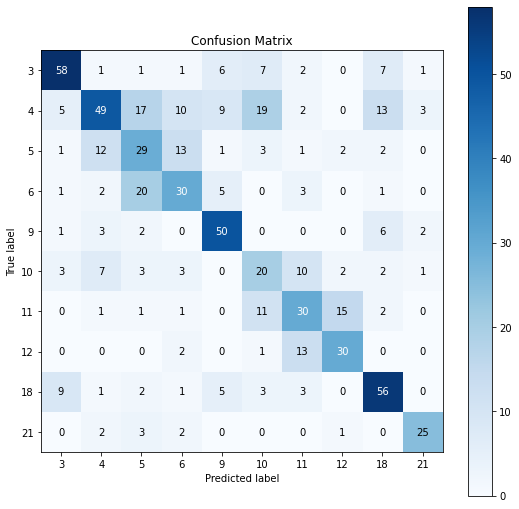

- Iterazione 0.5
IF 50
- Fit 50
- accuracy_score
['0.5610119047619048', '0.4163568773234201']
- confusion_matrix


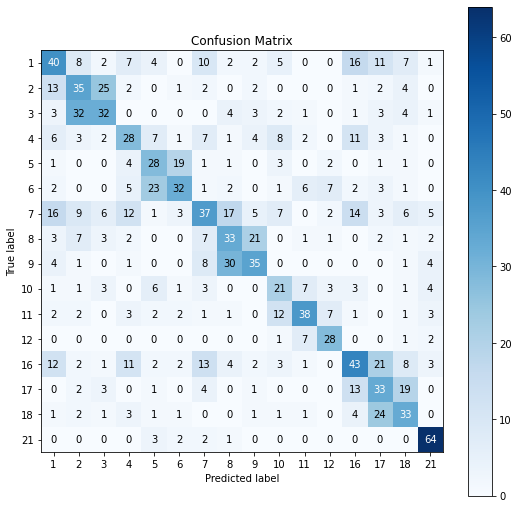

- Iterazione 0.75
IF 75
- Fit 75
- accuracy_score
['0.5610119047619048', '0.4163568773234201', '0.4030738720872583']
- confusion_matrix


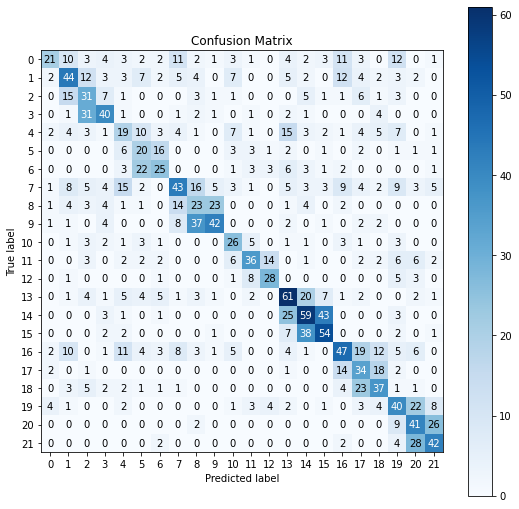

- Iterazione 1
IF 100
- Fit 1
- accuracy_score
['0.5610119047619048', '0.4163568773234201', '0.4030738720872583', '0.49479553903345724']
- confusion_matrix


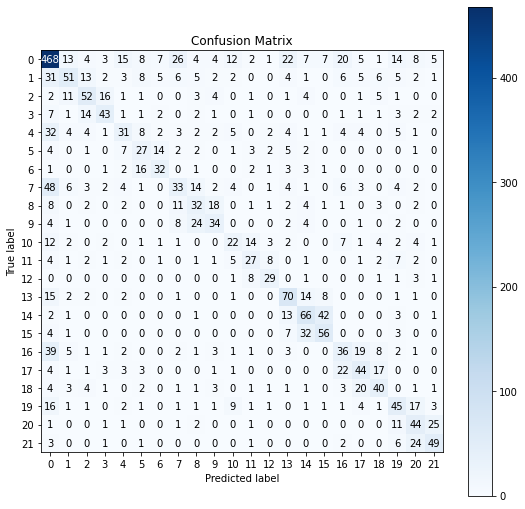

In [6]:
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

import scikitplot as skplt

import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

listMultiClass = ['Anger 0-33', 'Anger 33-66', 'Anger 66-100', 'Contempt 0-33', 'Contempt 33-66', 'Contempt 66-100',
                  'Disgust 0-33', 'Disgust 33-66', 'Disgust 66-100', 'Fear 0-33', 'Fear 33-66', 'Fear 66-100',
                  'Happy 0-33', 'Happy 33-66', 'Happy 66-100', 'Sadness 0-33', 'Sadness 33-66', 'Sadness 66-100',
                  'Surprise 0-33', 'Surprise 33-66', 'Surprise 66-100']
WEIGHTS = [0.25, 0.50, 0.75, 1]

pathHeatMap = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/Heatmap')
pathCsvAllDat = os.path.abspath(os.getcwd() + '/drive/Shareddrives/Progetto_FVAB/AllDataset')
fileCsvAllDat = pathCsvAllDat + '/allDatasetGlobale.csv'

FEATURES = ['name']
help1 = []
for x in range(1, 469):
    help1.append(str(x))
FEATURES.extend([help1])
FEATURES.extend(['emoclassname'])
FEATURES.extend(['emoclassnum'])


def get_measure_accuracy(labels, y_test, y_pred):
    n_labels = int(len(labels))
    measures = []
    init_values = []
    for i in range(n_labels):
        init_values.append(0)
    for i in range(n_labels):
        measures.append(init_values.copy())

    n_test = int(len(y_test))
    for i in range(n_test):
        # print(y_test[i], y_pred[i])
        label_expect = y_test[i]
        label_predict = y_pred[i]
        measures[label_expect][label_predict] += 1

    return pd.DataFrame(data=measures, index=labels, columns=labels)


def create_heatmap(df, name_file):
    df_copy = df.copy()
    df_copy = df_copy.apply(lambda x: round(x / x.sum(), 2), axis=1)

    plt.rcParams["figure.figsize"] = (9.0, 9.0)
    fig, ax = plt.subplots()
    ax = sns.heatmap(df_copy, annot=True)
    fig.tight_layout()
    fig.savefig(name_file, dpi=100)
    plt.close()
    return np.diag(df_copy)


def __delete_string_columns__(df):
    cols_to_remove = []
    for col in df.columns:
        try:
            _ = df[col].astype(float)
        except ValueError:
            cols_to_remove.append(col)
            pass
    df_ = df[[col for col in df.columns if col not in cols_to_remove]]
    return df_


class Sample:
    def __init__(self, csv, list_multclass=[]):
        self.labels_ = []
        self.df_list_ = []
        self.min_ = 0

        df = pd.read_csv(csv, encoding='utf-8')
        df.columns = df.columns.str.lower()
        self.df_list_.append(df.loc[df['emoclassnum'] == 0])
        self.labels_.append('Neutral')

        df_multClass = df.loc[df['emoclassnum'] != 0]
        for multclas in listMultiClass:
            self.df_list_.append(df_multClass.loc[df_multClass['emoclassname'] == multclas])
            self.labels_.append(multclas)

        # self.labels_.sort()
        self.df_list_.sort(key=lambda d: d.shape[0])
        self.labels_ = []

        for df in self.df_list_:
            label = df['emoclassname'].values[0]
            self.labels_.append(label)

        self.df_sample_ = pd.DataFrame(columns=self.df_list_[0].columns.values)
        for df in self.df_list_:
            self.df_sample_ = self.df_sample_.append(df)
        self.__update_status__()
        self.min_ = self.df_list_[0].shape[0]

    def __update_status__(self):
        self.list_n_entry = []
        for label in self.df_sample_:
            self.list_n_entry.append(self.df_sample_.loc[self.df_sample_['emoclassname'] == label].shape[0])

    def extract_sub_df(self, features, path=None):
        sub_df = None
        init = False
        y = self.df_sample_['emoclassnum'].copy()
        for feature in features:
            try:
                if not init:
                    column = self.df_sample_[feature].values
                    sub_df = pd.DataFrame(data=column, columns=[feature])
                    init = True
                else:
                    sub_df[feature] = self.df_sample_[feature].values
            except KeyError:
                print('Ignore the', feature, 'features...')
        if path is not None:
            sub_df.to_csv(path)
        sub_df = __delete_string_columns__(sub_df)
        return sub_df, y

    def get_list_emoClassPer(self):
        return np.roll(self.labels_.copy(), 1)

    def generate_weighted_df(self, weight=1, path=None):

        df_sample_ = pd.DataFrame(columns=self.df_list_[0].columns.values)

        n_df = int(len(self.df_list_))
        for i in range(n_df):
            df = self.df_list_[i].copy()
            increment = int(self.min_ * (1 + weight) ** i)

            if df.shape[0] >= increment:
                df_sample_ = df_sample_.append(df.sample(n=increment))
            else:
                df_sample_ = df_sample_.append(df)
        if path is not None:
            df_sample_.to_csv(path)
        self.df_sample_ = df_sample_

        self.__update_status__()
        return self.df_sample_.copy()


sample = Sample(fileCsvAllDat, list_multclass=listMultiClass)
accuracies = []
clf = svm.SVC(kernel='linear')

sm = SMOTE()
accu_tot_score = []

# Per ogni quarto di dataset (25, 50, 75, 100) 
for weight in WEIGHTS:
    print("- Iterazione", weight)
    sample.generate_weighted_df(weight=weight)
    df, labels = sample.extract_sub_df(features=FEATURES)
    X = df.iloc[:, :468].values
    y = labels.values
    y = y.astype('int')
    X = StandardScaler().fit_transform(X)
    lines_X, columns_X = X.shape

    if weight == 0.25:
        # Estrazione del 25% dei dati dal dataset
        lines_25 = math.floor((lines_X * 25)/100)
        X_25 = X[:lines_25, :]
        y_25 = y[:lines_25]
        print("IF 25")
        X_train, X_test, y_train, y_test = train_test_split(X_25, y_25, random_state=42, test_size=0.3, stratify=y_25)

        # Augumentation 
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
        print("- Fit 25")
        clf.fit(X_train_res, y_train_res)

        y_pred = clf.predict(X_test)

        # Accuracy della SVC sul 25% del dataset + augumentation
        print("- accuracy_score")
        accuracy_score = str(metrics.accuracy_score(y_test, y_pred))
        accu_tot_score.append(accuracy_score)
        print(accu_tot_score)

        # Pesatura sul 25% del dataset
        measure_accuracy = get_measure_accuracy(sample.get_list_emoClassPer(), y_test, y_pred)
        accuracy = create_heatmap(measure_accuracy, pathHeatMap + '/heatmap_global_augum_weight_' + str(weight) + '.png')
        accuracies.append(accuracy)

        # Creazione della matrice di confusione sul 25% del dataset
        print("- confusion_matrix")
        skplt.metrics.plot_confusion_matrix(y_pred, y_test)
        plt.show()

    if weight == 0.50:
        # Estrazione del 50% dei dati dal dataset
        lines_50 = math.floor((lines_X * 50)/100)
        X_50 = X[:lines_50, :]
        y_50 = y[:lines_50]

        print("IF 50")
        X_train, X_test, y_train, y_test = train_test_split(X_50, y_50, random_state=42, test_size=0.3, stratify=y_50)

        # Augumentation
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

        print("- Fit 50")
        clf.fit(X_train_res, y_train_res)
        y_pred = clf.predict(X_test)

        # Accuracy della SVC sul 50% del dataset + augumentation    
        print("- accuracy_score")
        accuracy_score = str(metrics.accuracy_score(y_test, y_pred))
        accu_tot_score.append(accuracy_score)
        print(accu_tot_score)

        # Pesatura sul 50% del dataset
        measure_accuracy = get_measure_accuracy(sample.get_list_emoClassPer(), y_test, y_pred)
        accuracy = create_heatmap(measure_accuracy, pathHeatMap + '/heatmap_global_augum_weight_' + str(weight) + '.png')
        accuracies.append(accuracy)

        # Creazione della matrice di confusione sul 50% del dataset
        print("- confusion_matrix")
        skplt.metrics.plot_confusion_matrix(y_pred, y_test)
        plt.show()

    if weight == 0.75:
        # Estrazione del 75% dei dati dal dataset
        lines_75 = math.floor((lines_X * 75)/100)
        X_75 = X[:lines_75, :]
        y_75 = y[:lines_75]

        print("IF 75")
        X_train, X_test, y_train, y_test = train_test_split(X_75, y_75, random_state=42, test_size=0.3, stratify=y_75)

        # Augumentation
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

        print("- Fit 75")
        clf.fit(X_train_res, y_train_res)
        y_pred = clf.predict(X_test)

        # Accuracy della SVC sul 75% del dataset + augumentation
        print("- accuracy_score")
        accuracy_score = str(metrics.accuracy_score(y_test, y_pred))
        accu_tot_score.append(accuracy_score)
        print(accu_tot_score)

        # Pesatura sul 75% del dataset
        measure_accuracy = get_measure_accuracy(sample.get_list_emoClassPer(), y_test, y_pred)
        accuracy = create_heatmap(measure_accuracy, pathHeatMap + '/heatmap_global_augum_weight_' + str(weight) + '.png')
        accuracies.append(accuracy)

        # Creazione della matrice di confusione sul 75% del dataset
        print("- confusion_matrix")
        skplt.metrics.plot_confusion_matrix(y_pred, y_test)
        plt.show()

    if weight == 1:
        # Estrazione del 100% dei dati dal dataset
        lines_1 = math.floor((lines_X * 100)/100)
        X_1 = X[:lines_1, :]
        y_1 = y[:lines_1]

        print("IF 100")
        X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, random_state=42, test_size=0.3, stratify=y_1)

        # Augumentation
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

        print("- Fit 1")
        clf.fit(X_train_res, y_train_res)
        y_pred = clf.predict(X_test)

        # Accuracy della SVC sul 100% del dataset + augumentation
        print("- accuracy_score")
        accuracy_score = str(metrics.accuracy_score(y_test, y_pred))
        accu_tot_score.append(accuracy_score)
        print(accu_tot_score)

        # Pesatura sul 100% del dataset
        measure_accuracy = get_measure_accuracy(sample.get_list_emoClassPer(), y_test, y_pred)
        accuracy = create_heatmap(measure_accuracy, pathHeatMap + '/heatmap_global_augum_weight_' + str(weight) + '.png')
        accuracies.append(accuracy)

        # Creazione della matrice di confusione sul 100% del dataset
        print("- confusion_matrix")
        skplt.metrics.plot_confusion_matrix(y_pred, y_test)
        plt.show()

print("Fine programma")
